<a href="https://colab.research.google.com/github/r-kovalch/acter-ner/blob/main/notebooks/acter-cvalue-rerank-annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/r-kovalch/acter-ner

fatal: destination path 'acter-ner' already exists and is not an empty directory.


In [3]:
!git clone https://github.com/lang-uk/extractomat.git

fatal: destination path 'extractomat' already exists and is not an empty directory.


In [4]:
!git clone https://github.com/AylaRT/ACTER

fatal: destination path 'ACTER' already exists and is not an empty directory.


In [5]:
!pip install -q \
  numpy==1.26.4 \
  spacy \
  spacy-layout \
  sentence-transformers \
  gitpython \
  matplotlib \
  tqdm -q

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 130.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
!ls

ACTER			acter-ner	extractomat	val_full.tsv
acter_en_gt.csv		drive		sample_data
acter_en_unlabeled.txt	dummy_test.tsv	train_full.tsv


In [7]:
import subprocess, sys
from pathlib import Path

# IOB directories inside the cloned ACTER repository
io_dirs = [
    "/content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
    "/content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/",
]

# Output files (80 % train, 20 % validation, no test set)
train_tsv = Path("train_full.tsv")
val_tsv   = Path("val_full.tsv")     # ← our gold set
# dummy test file because the script requires one
test_tsv  = Path("dummy_test.tsv")

args = [
    "python", "/content/acter-ner/term_extractor/preprocess_acter.py",
    "--input_dirs", *io_dirs,
    "--train_output", str(train_tsv),
    "--test_output",  str(test_tsv),
    "--val_output",   str(val_tsv),
    "--test_size", "0.0",            # no test set – everything goes to val
    "--val_size",  "0.2",            # 20 % of data kept with labels
    "--seed",      "42",
]

print("⏳ Running:", " ".join(args))
subprocess.check_call(args)
print("✓ Splits ready →", train_tsv, "and", val_tsv)


⏳ Running: python /content/acter-ner/term_extractor/preprocess_acter.py --input_dirs /content/ACTER/en/corp/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/equi/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/htfl/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ /content/ACTER/en/wind/annotated/annotations/sequential_annotations/iob_annotations/without_named_entities/ --train_output train_full.tsv --test_output dummy_test.tsv --val_output val_full.tsv --test_size 0.0 --val_size 0.2 --seed 42
✓ Splits ready → train_full.tsv and val_full.tsv


In [8]:
UNLABELED_TXT = Path("acter_en_unlabeled.txt")      # 80 % raw text
with UNLABELED_TXT.open("w", encoding="utf-8") as out_txt:
    sentence = []
    for line in train_tsv.read_text(encoding="utf-8").splitlines():
        if not line.strip():                   # sentence boundary
            if sentence:
                out_txt.write(" ".join(sentence) + "\n")
                sentence = []
            continue
        token, *_ = line.split("\t")
        sentence.append(token)
    if sentence:                               # trailing sentence
        out_txt.write(" ".join(sentence) + "\n")
print(f"✓ Unlabeled corpus written → {UNLABELED_TXT} ({UNLABELED_TXT.stat().st_size/1e6:.1f} MB)")

✓ Unlabeled corpus written → acter_en_unlabeled.txt (1.0 MB)


In [9]:
# Cell 4b – rebuild gold-term list by grouping B/I spans from val_full.tsv

from pathlib import Path
import csv

VAL_TSV = Path("val_full.tsv")
GT_CSV  = Path("acter_en_gt.csv")

terms = set()
current = []

for line in VAL_TSV.read_text(encoding="utf-8").splitlines():
    if not line.strip():
        # sentence break → flush any ongoing term
        if current:
            terms.add(" ".join(current).lower())
            current = []
        continue

    token, label = line.split("\t")
    # labels are like "B-TERM", "I-TERM", or "O"
    if label.startswith("B"):
        # start a new term (flush old one first)
        if current:
            terms.add(" ".join(current).lower())
        current = [token]
    elif label.startswith("I") and current:
        # continuation of the current term
        current.append(token)
    else:
        # outside a term → flush
        if current:
            terms.add(" ".join(current).lower())
            current = []

# catch any trailing term
if current:
    terms.add(" ".join(current).lower())

# write out CSV: one term per line
with GT_CSV.open("w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    for t in sorted(terms):
        writer.writerow([t])

print(f"✓ Rebuilt gold CSV with {len(terms):,} unique terms → {GT_CSV}")


✓ Rebuilt gold CSV with 2,235 unique terms → acter_en_gt.csv


In [10]:
sys.path.insert(0, str(Path.cwd() / "extractomat"))

from pathlib import Path
import spacy
from matcha import cvalue
from tester import TermEvaluator


GT_CSV        = Path("acter_en_gt.csv")             # 20 % gold terms

# 1️⃣ Linguistic pre-processing (tokenise, lemmatise) – any spaCy EN model works
nlp = spacy.load("en_core_web_sm", disable=["ner"])
doc = nlp(UNLABELED_TXT.read_text().lower())

#  2️⃣ C-Value scoring (nested n-grams 2…8 tokens, with slight smoothing)
term_scores, term_occ = cvalue(
    doc,
    n_min=1,     # smallest n-gram to consider
    n_max=4,     # longest n-gram
    smoothing=0.1
)

print(f"Extracted {len(term_scores):,} candidate terms")

Extracted 24,479 candidate terms


In [11]:
# Cell 5b – robust threshold sweep for C-Value
import numpy as np
from tester import TermEvaluator

# 1) Instantiate the evaluator once:
evaluator = TermEvaluator(
    "acter_en_gt.csv",    # your 20% GT-term list from Step 4
    term_scores,          # from Cell 5
    term_occ,             # from Cell 5
    method="cvalue",
    language="en"
)

# 2) Build 100 thresholds from just below min(score) up to max(score):
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

best = {"f1": -1.0}

# 3) Sweep, catching any zero-division cases:
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        # no candidates or no GT terms at this t → skip
        continue
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)


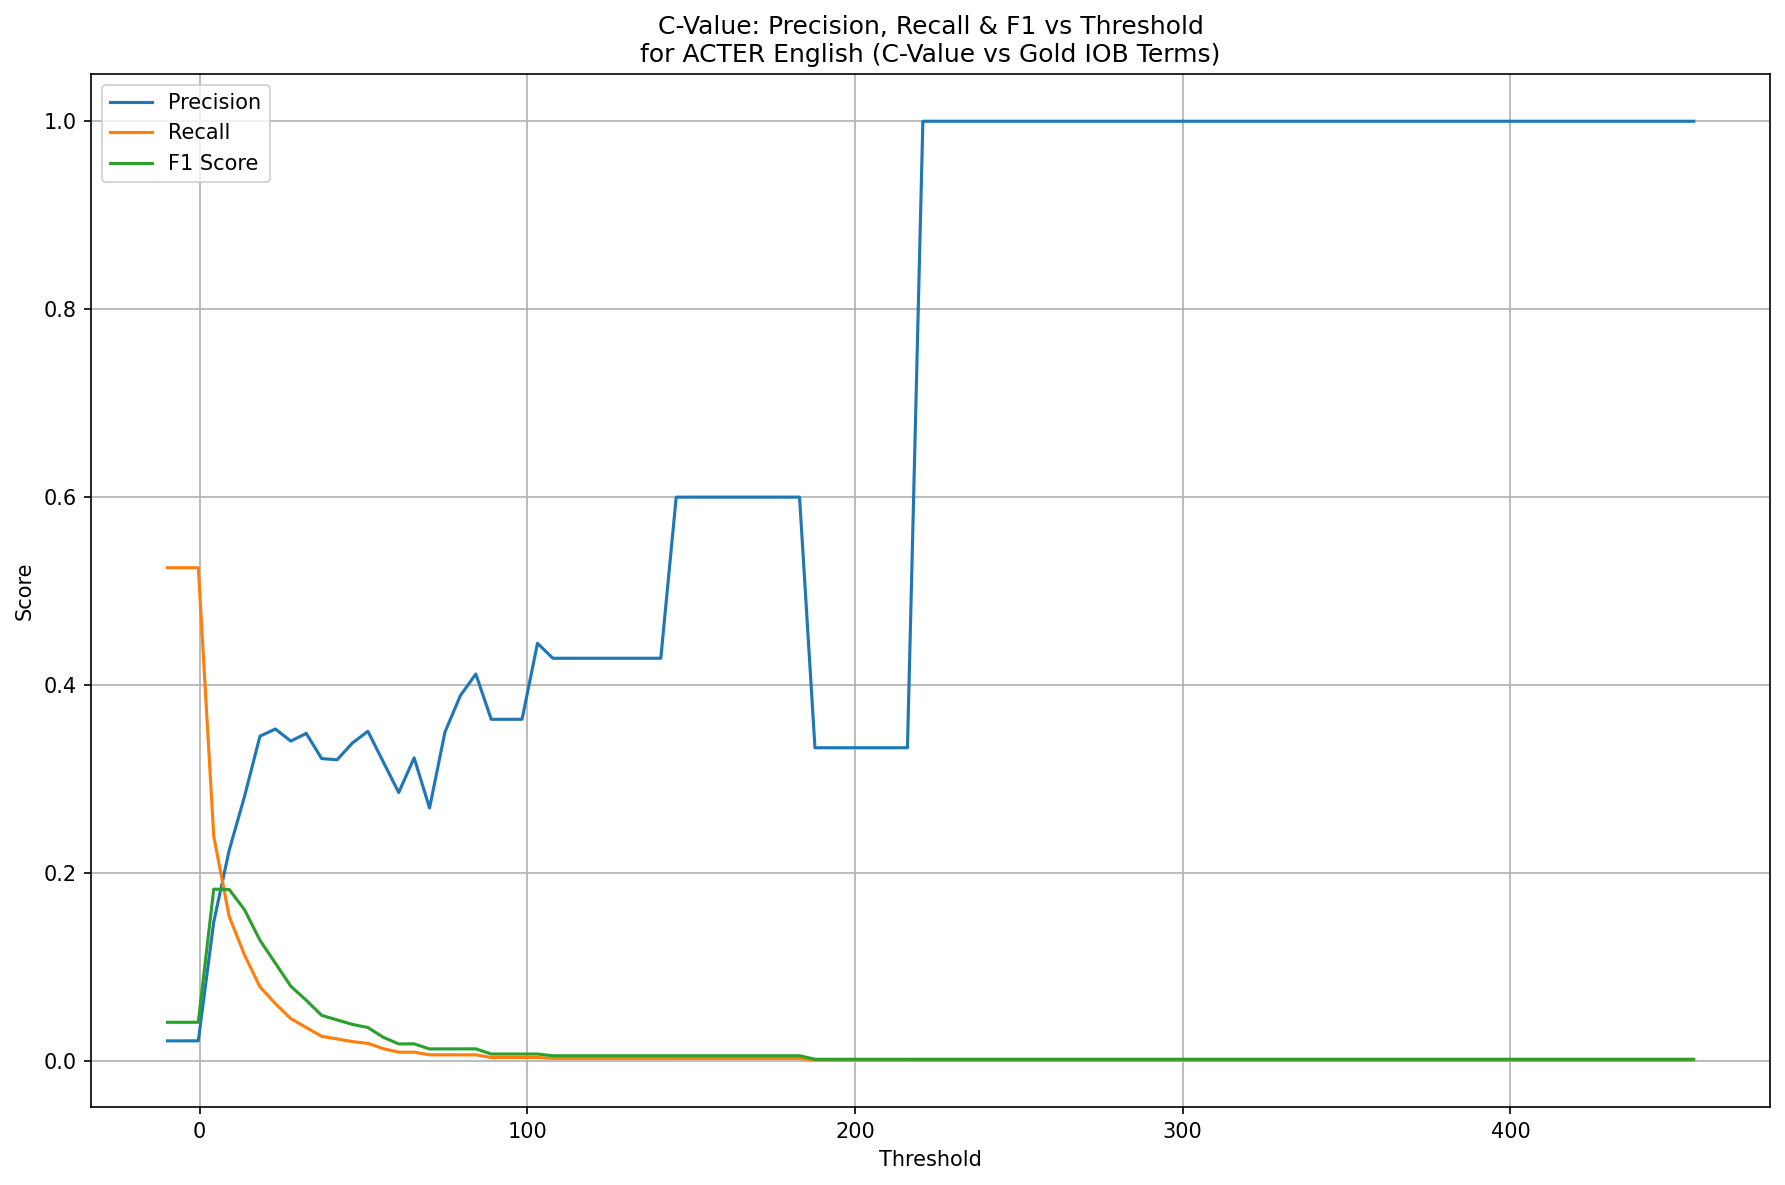

▶ Best C-Value results (threshold sweep):
   threshold = 4.31882
   precision = 0.148
   recall    = 0.239
   F1        = 0.183


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from pathlib import Path
from extractomat.tester import TermEvaluator

# ── evaluator setup ───────────────────────────────────────────────────────
evaluator = TermEvaluator(
    "acter_en_gt.csv",   # Gold-standard terms from IOB validation
    term_scores,         # your C-Value scores
    term_occ,            # your occurrence dict
    method="cvalue",
    language="en"
)

# ── threshold sweep ────────────────────────────────────────────────────────
scores = np.array(list(term_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

precisions, recalls, f1_scores = [], [], []
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# ── plotting ──────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("C-Value: Precision, Recall & F1 vs Threshold\nfor ACTER English (C-Value vs Gold IOB Terms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("▶ Best C-Value results (threshold sweep):")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")



In [13]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from extractomat.sbert_reranker import SentenceSimilarityCalculator

# ── load torch & SBERT (GPU if available) ─────────────────────────────────
import torch
from sentence_transformers import SentenceTransformer  # imported for completeness

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 SBERT device → {device}")

# ── instantiate the reranker correctly ────────────────────────────────────
reranker = SentenceSimilarityCalculator(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    device=device
)

# ── re-rank your C-Value candidates ───────────────────────────────────────
reranked_scores = reranker.rerank_terms_in_doc(
    doc,             # spaCy Doc from C-Value step
    term_occ,        # occurrences dict from C-Value step
    context_len=3,
    pooling="max"
)
print(f"✅ Re-ranked {len(reranked_scores):,} terms")

🔧 SBERT device → cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Re-ranked 24,479 terms


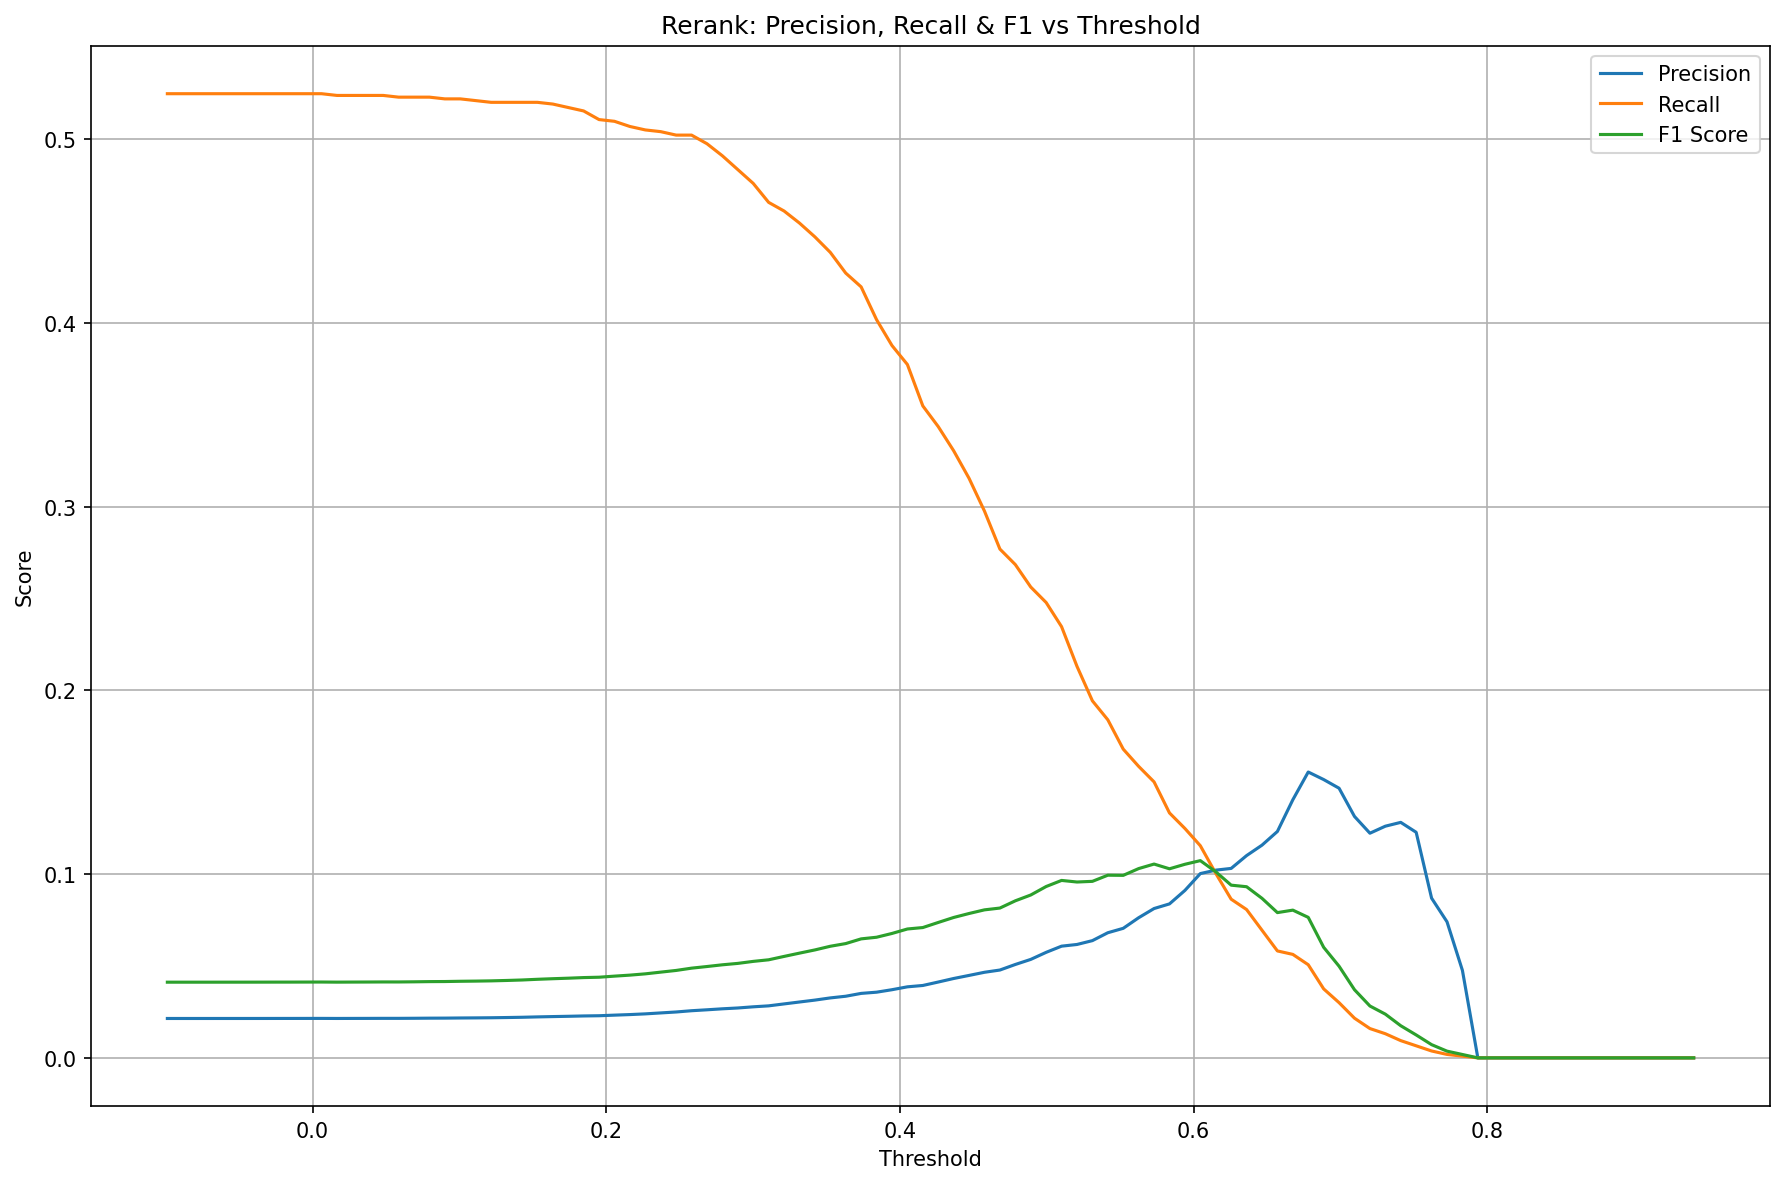

▶ Best Rerank results (threshold sweep):
   threshold = 0.60451
   precision = 0.100
   recall    = 0.115
   F1        = 0.107


In [15]:
evaluator = TermEvaluator(
    "acter_en_gt.csv",    # your GT-term CSV
    reranked_scores,      # the new rerank scores
    term_occ,
    method="rerank",
    language="en"
)

# ── 5) Build a 100-point threshold grid ───────────────────────────────────────
scores = np.array(list(reranked_scores.values()))
t_min, t_max = scores.min(), scores.max()
thresholds = np.linspace(t_min - 1e-9, t_max, num=100)

# ── 6) Sweep & collect P/R/F1 ────────────────────────────────────────────────
precisions, recalls, f1_scores = [], [], []
best = {"f1": -1.0}
for t in thresholds:
    try:
        p, r, f1 = evaluator.calculate_metrics(t)
    except ZeroDivisionError:
        p = r = f1 = 0.0
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)
    if f1 > best["f1"]:
        best.update(threshold=t, precision=p, recall=r, f1=f1)

# ── 7) Plot Precision / Recall / F1 vs Threshold ─────────────────────────────
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1_scores,  label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Rerank: Precision, Recall & F1 vs Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ── 8) Print best‐found threshold and metrics ────────────────────────────────
print("▶ Best Rerank results (threshold sweep):")
print(f"   threshold = {best['threshold']:.5f}")
print(f"   precision = {best['precision']:.3f}")
print(f"   recall    = {best['recall']:.3f}")
print(f"   F1        = {best['f1']:.3f}")

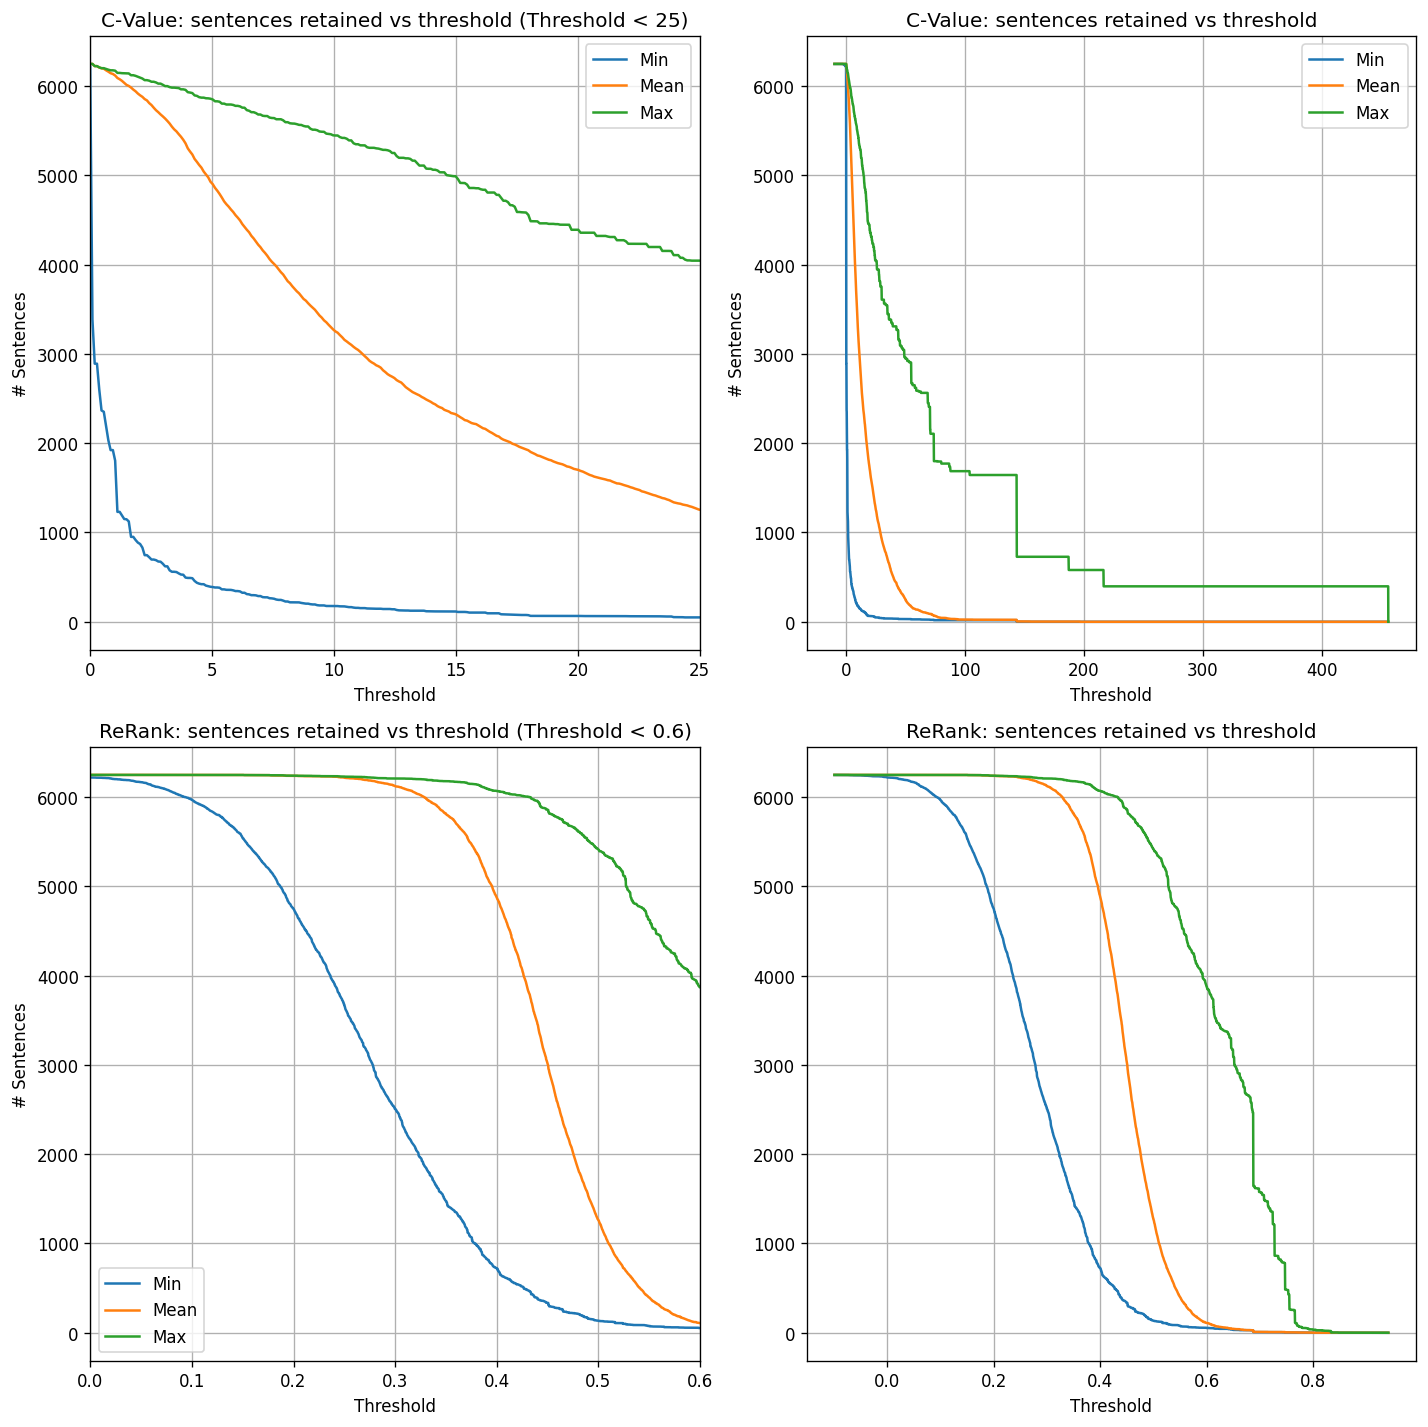

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import copy

# ---------------------------------------------------------------------------
# This cell assumes term_scores, term_occ, and reranked_scores are already
# defined from your earlier C‑Value and ReRank steps.
# ---------------------------------------------------------------------------

# 1) Bucket all scores that belong to each sentence
bucket_c, bucket_r = defaultdict(list), defaultdict(list)

for term, spans in term_occ.items():
    c_val = term_scores[term]
    r_val = reranked_scores.get(term, None)
    for span in spans:
        s = span.sent  # spaCy sentence object
        bucket_c[s].append(c_val)
        if r_val is not None:
            bucket_r[s].append(r_val)

# 2) Compute per‑sentence min / mean / max
def per_sentence_stats(bucket):
    mins, means, maxs = [], [], []
    for scores in bucket.values():
        mins.append(min(scores))
        means.append(np.mean(scores))
        maxs.append(max(scores))
    return np.array(mins), np.array(means), np.array(maxs)

c_min, c_mean, c_max = per_sentence_stats(bucket_c)
r_min, r_mean, r_max = per_sentence_stats(bucket_r)

stat_arrays = {
    "C-Value": {"min": c_min, "mean": c_mean, "max": c_max},
    "ReRank":  {"min": r_min, "mean": r_mean, "max": r_max}
}

# 3) Threshold ranges (use overall min/max of each method)
thr_c = np.linspace(c_min.min(), c_max.max(), 5000)
thr_r = np.linspace(r_min.min(), r_max.max(), 5000)

# 4) Compute sentence counts (not rates) above each threshold
cnt_c = {stat: [int((arr > t).sum()) for t in thr_c]
         for stat, arr in stat_arrays["C-Value"].items()}
cnt_r = {stat: [int((arr > t).sum()) for t in thr_r]
         for stat, arr in stat_arrays["ReRank"].items()}

# 5) Plot: #sentences retained vs threshold
fig, (ax0_ax1, ax2_ax3) = plt.subplots(2, 2, figsize=(12, 12), dpi=120)

ax0, ax1 = ax0_ax1
ax2, ax3 = ax2_ax3

for stat in ["min", "mean", "max"]:
    ax0.plot(thr_c, cnt_c[stat], label=f"{stat.capitalize()}")
    ax1.plot(thr_c, cnt_c[stat], label=f"{stat.capitalize()}")
    ax2.plot(thr_r, cnt_r[stat], label=f"{stat.capitalize()}")
    ax3.plot(thr_r, cnt_r[stat], label=f"{stat.capitalize()}")

ax1.set_title("C‑Value: sentences retained vs threshold")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("# Sentences")
ax1.grid(True)
ax1.legend()

limit_thr = 25
ax0.set_title(f"C‑Value: sentences retained vs threshold (Threshold < {limit_thr})")
ax0.set_xlabel("Threshold")
ax0.set_ylabel("# Sentences")
ax0.set_xlim(0, limit_thr)
ax0.grid(True)
ax0.legend()

limit_thr_r = 0.6
ax2.set_title(f"ReRank: sentences retained vs threshold (Threshold < {limit_thr_r})")
ax2.set_xlabel("Threshold"); ax2.set_ylabel("# Sentences")
ax2.set_xlim(0, limit_thr_r)
ax2.grid(True); ax2.legend()

ax3.set_title("ReRank: sentences retained vs threshold")
ax3.set_xlabel("Threshold"); ax2.set_ylabel("# Sentences")
ax3.grid(True); ax2.legend()

plt.tight_layout(); plt.show()


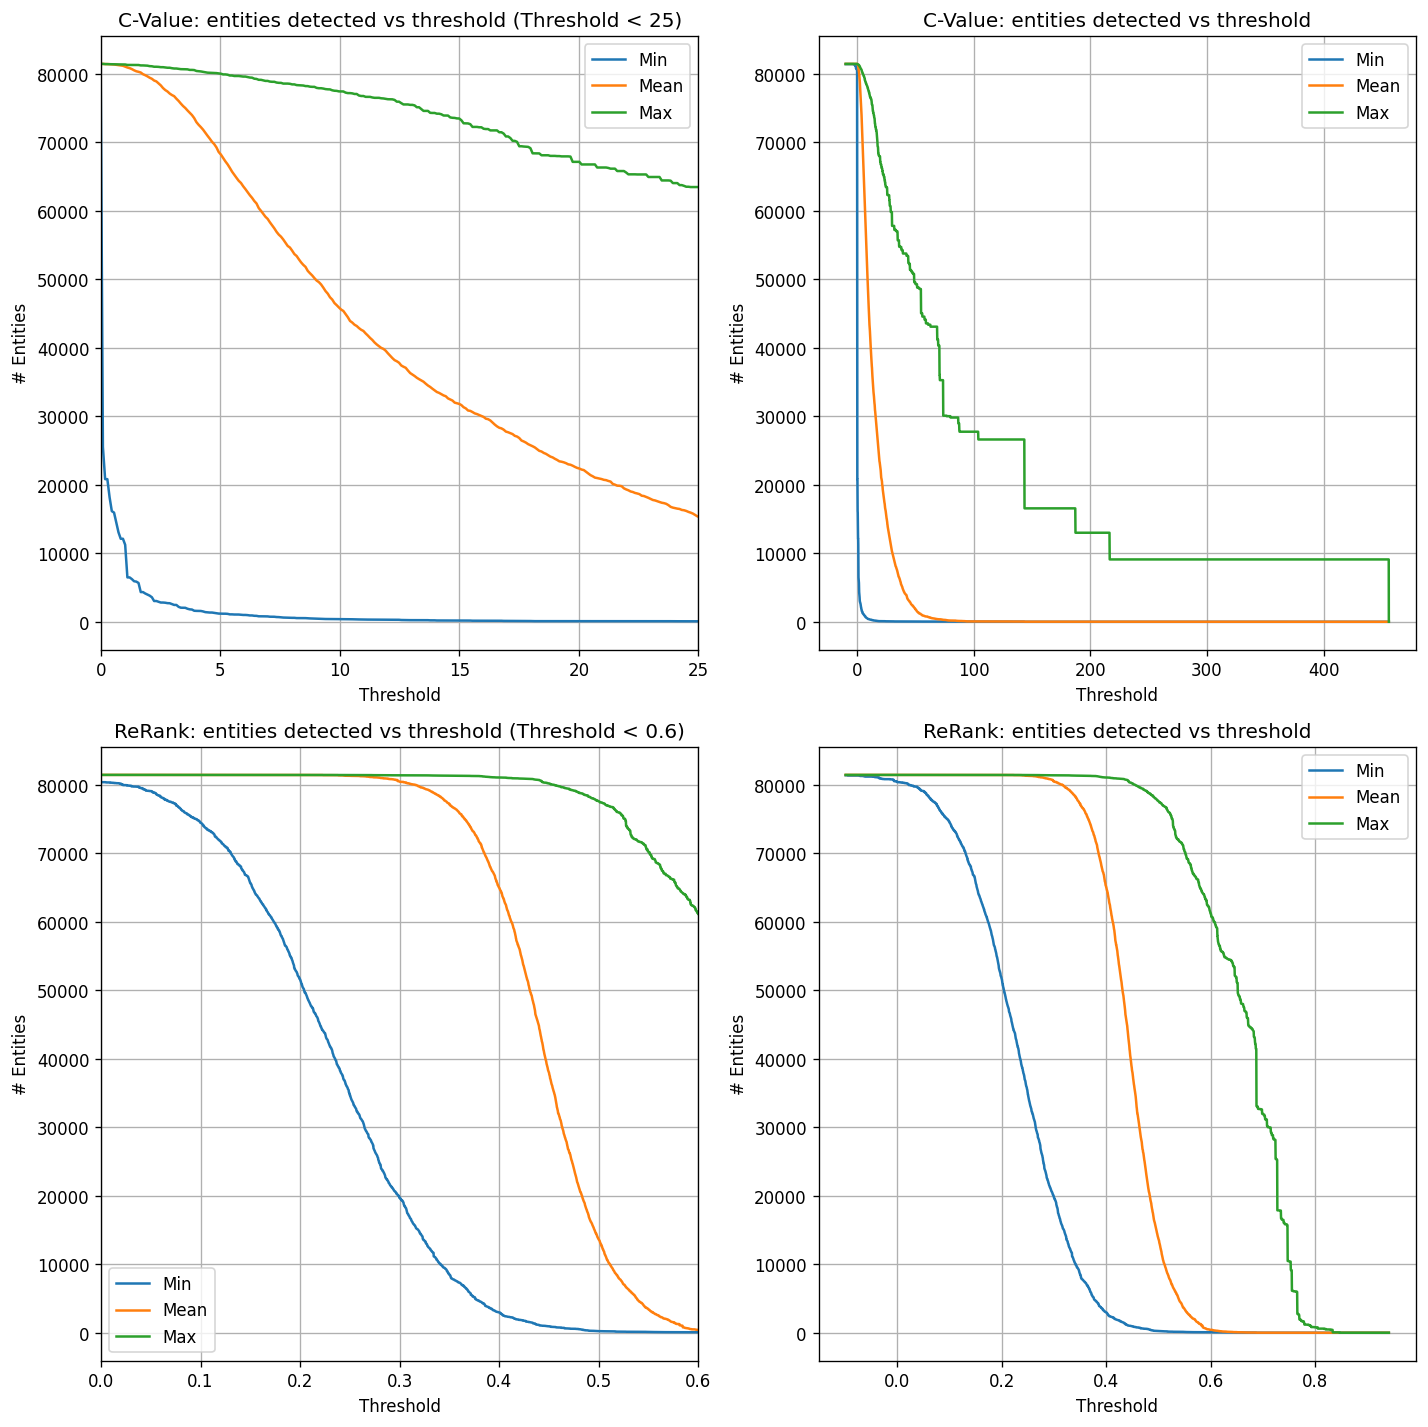

In [41]:
# ---------------------------------------------------------------------------
# Plot # of entities detected vs threshold for C-Value and ReRank (min, mean, max)
# ---------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# (Requires bucket_c, bucket_r, thr_c, thr_r, and stat_arrays from the previous cell)

# Prepare sentence lists corresponding to bucket_c and bucket_r
c_sents = list(bucket_c.keys())
r_sents = list(bucket_r.keys())

# Compute entity counts for each threshold and each statistic
cnt_c_ent = {
    stat: [
        sum(len(bucket_c[c_sents[i]]) for i, val in enumerate(arr) if val > t)
        for t in thr_c
    ]
    for stat, arr in stat_arrays["C-Value"].items()
}
cnt_r_ent = {
    stat: [
        sum(len(bucket_r[r_sents[i]]) for i, val in enumerate(arr) if val > t)
        for t in thr_r
    ]
    for stat, arr in stat_arrays["ReRank"].items()
}

# Plotting in a 2×2 grid
fig, ((ax_c_zoom, ax_c_full), (ax_r_zoom, ax_r_full)) = plt.subplots(2, 2, figsize=(12, 12), dpi=120)

# Plot lines for each statistic
for stat in ["min", "mean", "max"]:
    ax_c_zoom.plot(thr_c, cnt_c_ent[stat], label=stat.capitalize())
    ax_c_full.plot(thr_c, cnt_c_ent[stat], label=stat.capitalize())
    ax_r_zoom.plot(thr_r, cnt_r_ent[stat], label=stat.capitalize())
    ax_r_full.plot(thr_r, cnt_r_ent[stat], label=stat.capitalize())

# C-Value zoomed
ax_c_zoom.set_title("C-Value: entities detected vs threshold (Threshold < 25)")
ax_c_zoom.set_xlim(0, 25)
ax_c_zoom.set_xlabel("Threshold")
ax_c_zoom.set_ylabel("# Entities")
ax_c_zoom.grid(True)
ax_c_zoom.legend()

# C-Value full
ax_c_full.set_title("C-Value: entities detected vs threshold")
ax_c_full.set_xlabel("Threshold")
ax_c_full.set_ylabel("# Entities")
ax_c_full.grid(True)
ax_c_full.legend()

# ReRank zoomed
ax_r_zoom.set_title("ReRank: entities detected vs threshold (Threshold < 0.6)")
ax_r_zoom.set_xlim(0, 0.6)
ax_r_zoom.set_xlabel("Threshold")
ax_r_zoom.set_ylabel("# Entities")
ax_r_zoom.grid(True)
ax_r_zoom.legend()

# ReRank full
ax_r_full.set_title("ReRank: entities detected vs threshold")
ax_r_full.set_xlabel("Threshold")
ax_r_full.set_ylabel("# Entities")
ax_r_full.grid(True)
ax_r_full.legend()

plt.tight_layout()
plt.show()

In [38]:
thresholds = {
    "C-Value": {"min": 0.2, "mean": 5, "max": 15},
    "ReRank":  {"min": 0.1, "mean": 0.325, "max": 0.4}
}

In [39]:
import csv
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd
import shutil

# setup directories and paths
target_dir = Path("/content/drive/MyDrive/ucu/ner/threshold_datasets")
target_dir.mkdir(parents=True, exist_ok=True)

# 1) Validation TSV
val_full = target_dir / "val_full.tsv"
if val_full.exists():
    val_full.unlink()

# build validation TSV from acter_en_gt.csv
val_terms = set()
with open("acter_en_gt.csv", encoding="utf-8") as f:
    for line in f:
        term = line.strip().lower()
        if term:
            val_terms.add(term)

print(f"Writing validation TSV to {val_full}")
with val_full.open("w", encoding="utf-8") as fout:
    for sent in tqdm(doc.sents, desc="Val sentences"):
        tokens = [tok.text for tok in sent]
        labels = ["O"] * len(tokens)
        tl = [t.lower() for t in tokens]
        for term in val_terms:
            parts = term.split()
            n = len(parts)
            for i in range(len(tokens) - n + 1):
                if tl[i:i+n] == parts:
                    labels[i] = "B-TERM"
                    for j in range(i+1, i+n):
                        labels[j] = "I-TERM"
        for t, lbl in zip(tokens, labels):
            fout.write(f"{t}\t{lbl}\n")
        fout.write("\n")

# map sentences to spans (unchanged)
sent2spans = defaultdict(list)
for term, spans in term_occ.items():
    sc = term_scores.get(term, 0.0)
    sr = reranked_scores.get(term, None)
    for span in spans:
        sent2spans[span.sent].append((span, sc, sr))
sentences = list(doc.sents)

# 2) Train TSVs + stats collection
stats = []

for method, agg_map in thresholds.items():
    for agg_name, thr in agg_map.items():
        fname = f"{method}_{agg_name}_{thr}_train_full.tsv"
        out_path = target_dir / fname
        # delete if it already exists
        if out_path.exists():
            out_path.unlink()

        b_cnt = i_cnt = o_cnt = sent_cnt = 0
        with out_path.open("w", encoding="utf-8") as fout:
            for sent in tqdm(sentences, desc=f"Writing {fname}", unit="sent"):
                spans = sent2spans.get(sent, [])
                scores = [sc if method=="C-Value" else sr for _, sc, sr in spans]
                if not scores:
                    continue
                if agg_name == "min":
                    metric = min(scores)
                elif agg_name == "mean":
                    metric = sum(scores)/len(scores)
                else:
                    metric = max(scores)
                if metric < thr:
                    continue

                labels = ["O"] * len(sent)
                for span, sc, sr in spans:
                    score = sc if method=="C-Value" else sr
                    if score < thr:
                        continue
                    start = span.start - sent.start
                    end   = span.end   - sent.start
                    if start < 0 or end <= start:
                        continue
                    labels[start] = "B-TERM"
                    for j in range(start+1, min(end, len(labels))):
                        labels[j] = "I-TERM"

                for token, lbl in zip(sent, labels):
                    if lbl == "O":
                        o_cnt += 1
                    elif lbl == "B-TERM":
                        b_cnt += 1
                    else:
                        i_cnt += 1
                    fout.write(f"{token.text}\t{lbl}\n")
                fout.write("\n")
                sent_cnt += 1

        # record stats: entity‐tokens = B + I
        stats.append({
            'method': method,
            'aggregation_method': agg_name,
            'threshold': thr,
            '#sentences': sent_cnt,
            '#entities': b_cnt + i_cnt,
            '#i': i_cnt,
            '#o': o_cnt,
            '#b': b_cnt
        })
        print(f"Wrote {fname}: sentences={sent_cnt}, B={b_cnt}, I={i_cnt}, O={o_cnt}")

# 3) Display summary table
df = pd.DataFrame(stats,
                  columns=['method','aggregation_method','threshold',
                           '#sentences','#entities','#i','#o','#b'])
from IPython.display import display
display(df)

Writing validation TSV to /content/drive/MyDrive/ucu/ner/threshold_datasets/val_full.tsv


Val sentences: 0it [00:00, ?it/s]

Writing C-Value_min_0.2_train_full.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

Wrote C-Value_min_0.2_train_full.tsv: sentences=2891, B=12039, I=6724, O=48489


Writing C-Value_mean_5_train_full.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

Wrote C-Value_mean_5_train_full.tsv: sentences=4907, B=22956, I=9010, O=128073


Writing C-Value_max_15_train_full.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

Wrote C-Value_max_15_train_full.tsv: sentences=4958, B=13139, I=5149, O=149099


Writing ReRank_min_0.1_train_full.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

Wrote ReRank_min_0.1_train_full.tsv: sentences=5969, B=32792, I=28228, O=116687


Writing ReRank_mean_0.325_train_full.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

Wrote ReRank_mean_0.325_train_full.tsv: sentences=6023, B=33135, I=24223, O=129578


Writing ReRank_max_0.4_train_full.tsv:   0%|          | 0/6938 [00:00<?, ?sent/s]

Wrote ReRank_max_0.4_train_full.tsv: sentences=6069, B=28289, I=19429, O=142117


,method,aggregation_method,threshold,#sentences,#entities,#i,#o,#b
0,C-Value,min,0.200,2891,18763,6724,48489,12039
1,C-Value,mean,5.000,4907,31966,9010,128073,22956
2,C-Value,max,15.000,4958,18288,5149,149099,13139
3,ReRank,min,0.100,5969,61020,28228,116687,32792
4,ReRank,mean,0.325,6023,57358,24223,129578,33135
5,ReRank,max,0.400,6069,47718,19429,142117,28289


In [42]:
from google.colab import runtime
runtime.unassign()